# Curso Kaggle - Feature Engineering

https://www.kaggle.com/learn/feature-engineering

In [14]:
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

O objetivo do Feature Engineering é simplesmente tornar seus dados mais adequados ao problema em questão.

* Melhorar o desempenho preditivo de um modelo
* Reduzir as necessidades computacionais ou de dados
* Melhorar a interpretabilidade dos resultados

Princípio orientador da engenharia de recursos.

Para que um recurso seja útil, ele deve ter um relacionamento com o destino que seu modelo seja capaz de aprender.

Os modelos lineares, por exemplo, só são capazes de aprender relações lineares. 

Portanto, ao usar um modelo linear, seu objetivo é transformar os recursos para tornar linear seu relacionamento com o alvo.

## Exemplo

Para ilustrar essas ideias, veremos como adicionar alguns recursos sintéticos a um conjunto de dados pode melhorar o desempenho preditivo de um modelo de floresta aleatória.

O conjunto de dados Concrete contém uma variedade de formulações de concreto e a resistência à compressão do produto resultante, que é uma medida de quanta carga esse tipo de concreto pode suportar. A tarefa para este conjunto de dados é prever a resistência à compressão de um concreto dada a sua formulação.

In [15]:
concrete = pd.read_excel('/home/franciscofoz/Documents/GitHub/machine-learning-training/Datasets/Concrete_Data.xls')
concrete.columns = ['Cement','BlastFurnaceSlag','FlyAsh','Water','Superplasticizer','CoarseAggregate','FineAggregate','Age','CompressiveStrength']
concrete

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


Você pode ver aqui os vários ingredientes que entram em cada variedade de concreto. Veremos em breve como adicionar alguns recursos sintéticos adicionais derivados deles pode ajudar um modelo a aprender relacionamentos importantes entre eles.

Primeiro, estabeleceremos uma linha de base treinando o modelo no conjunto de dados não aumentado. Isso nos ajudará a determinar se nossos novos recursos são realmente úteis.

Estabelecer linhas de base como essa é uma boa prática no início do processo de engenharia de recursos. Uma pontuação de linha de base pode ajudá-lo a decidir se vale a pena manter seus novos recursos ou se você deve descartá-los e possivelmente tentar outra coisa.

In [16]:
X = concrete.copy()
y = X.pop("CompressiveStrength")

# Treino e pontuação do baseline
baseline = RandomForestRegressor(criterion="absolute_error", random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="neg_mean_absolute_error"
)
baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.397


Se você já cozinhou em casa, deve saber que a proporção dos ingredientes em uma receita geralmente é um indicador melhor de como a receita acaba do que suas quantidades absolutas. 

Podemos raciocinar então que as proporções dos recursos acima seriam um bom preditor de CompressiveStrength.

A célula abaixo adiciona três novos recursos de proporção ao conjunto de dados.

In [17]:
X = concrete.copy()
y = X.pop("CompressiveStrength")

# Criação de features sintéticas
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

# Treinar e verificar a pontuação com as novas features
model = RandomForestRegressor(criterion="absolute_error", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")

MAE Score with Ratio Features: 8.01


O desempenho melhorou! 

Isso é uma evidência de que esses novos recursos de proporção expuseram informações importantes ao modelo que ele não estava detectando antes.

# Informação mútua

Às vezes, encontrar um novo conjunto de dados pode parecer esmagador. 
Você pode ser apresentado a centenas ou milhares de recursos sem nem mesmo uma descrição para seguir. 

Por onde você começa?

Um ótimo primeiro passo é construir uma classificação com uma métrica de utilitário de recurso, uma função que mede as associações entre um recurso e o alvo. Então você pode escolher um conjunto menor dos recursos mais úteis para desenvolver inicialmente e ter mais confiança de que seu tempo será bem gasto.

A métrica que usaremos é chamada de "informação mútua". A informação mútua é muito parecida com a correlação, pois mede uma relação entre duas quantidades. A vantagem da informação mútua é que ela pode detectar qualquer tipo de relacionamento, enquanto a correlação detecta apenas relacionamentos lineares.

A informação mútua é uma ótima métrica de uso geral e especialmente útil no início do desenvolvimento de recursos, quando você ainda não sabe qual modelo gostaria de usar. 
Isso é:

* fácil de usar e interpretar,
* computacionalmente eficiente,
* teoricamente bem fundamentado,
* resistente ao sobreajuste e,
* capaz de detectar qualquer tipo de relacionamento

## Informação mútua e o que ela mede

A informação mútua descreve os relacionamentos em termos de incerteza. 
A informação mútua (MI) entre duas quantidades é uma medida da medida em que o conhecimento de uma quantidade reduz a incerteza sobre a outra. 

Se você soubesse o valor de um recurso, quanto mais confiante você estaria sobre o alvo?

Aqui está um exemplo dos dados da Ames Housing. 
A figura mostra a relação entre a qualidade exterior de uma casa e o preço de venda.

Cada ponto representa uma casa.

![image.png](https://storage.googleapis.com/kaggle-media/learn/images/X12ARUK.png)




A partir da figura, podemos ver que saber o valor de ExterQual deve deixá-lo mais certo sobre o SalePrice correspondente -- cada categoria de ExterQual tende a concentrar o SalePrice dentro de um determinado intervalo. 

A informação mútua que ExterQual tem com SalePrice é a redução média da incerteza em SalePrice tomada sobre os quatro valores de ExterQual.

Como Razoável(Fair) ocorre com menos frequência do que Típico (Typical), por exemplo, Razoável recebe menos peso na pontuação do MI.

(Nota técnica: o que estamos chamando de incerteza é medido usando uma quantidade da teoria da informação conhecida como "entropia". A entropia de uma variável significa aproximadamente: "quantas perguntas sim ou não você precisaria para descrever uma ocorrência daquela variável, em média." Quanto mais perguntas você tem que fazer, mais incerto você deve estar sobre a variável. Informação mútua é quantas perguntas você espera que o recurso responda sobre o alvo.)

## Interpretando Pontuações de Informações Mútuas

A menor informação mútua possível entre grandezas é 0,0. 

Quando MI é zero, as quantidades são independentes: nenhuma pode dizer nada sobre a outra. Por outro lado, em teoria, não há limite superior para o que o MI pode ser. Na prática, porém, valores acima de 2,0 ou mais são incomuns. (A informação mútua é uma quantidade logarítmica, por isso aumenta muito lentamente.)

A próxima figura lhe dará uma ideia de como os valores de MI correspondem ao tipo e grau de associação que um recurso tem com o alvo.

![image](https://storage.googleapis.com/kaggle-media/learn/images/Dt75E1f.png)

*Esquerda: A informação mútua aumenta à medida que a dependência entre o recurso e o alvo se torna mais estreita.* 

*Direita: A informação mútua pode capturar qualquer tipo de associação (não apenas linear, como correlação).*

Aqui estão algumas coisas para lembrar ao aplicar informações mútuas:

* O MI pode ajudá-lo a entender o potencial relativo de um recurso como um preditor do alvo, considerado por si só.

* É possível que um recurso seja muito informativo ao interagir com outros recursos, mas não tão informativo sozinho. MI não pode detectar interações entre recursos. É uma métrica univariada.

* A utilidade real de um recurso depende do modelo com o qual você o usa. Um recurso só é útil na medida em que seu relacionamento com o alvo é aquele que seu modelo pode aprender. Só porque um recurso tem uma pontuação de MI alta não significa que seu modelo será capaz de fazer qualquer coisa com essa informação. Pode ser necessário transformar o recurso primeiro para expor a associação.

## Exemplo - Automóveis de 1985

O conjunto de dados Automobile consiste em 193 carros do ano modelo de 1985. O objetivo desse conjunto de dados é prever o preço de um carro (o alvo) a partir de 23 características do carro, como marca, estilo de carroceria e potência. 

Neste exemplo, classificaremos os recursos com informações mútuas e investigaremos os resultados por visualização de dados.


In [18]:
import pandas as pd
pd.options.display.max_columns = 999

df_auto = pd.read_csv('/home/franciscofoz/Documents/GitHub/machine-learning-training/Datasets/Automobile_data.csv')
df_auto


df_auto = df_auto.replace('?', pd.NA).dropna()

O algoritmo scikit-learn para MI trata as features discretas de maneira diferente das features contínuas.
Consequentemente, você precisa dizer quais são quais.
Como regra geral, qualquer coisa que deva ter um float dtype não é discreta. 

Categóricos (objeto ou categorial dtype) podem ser tratados como discretos, dando-lhes uma codificação de rótulos.


In [19]:
X = df_auto.copy()
y = X.pop("price").astype('int')

In [20]:
X

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10.0,102,5500,24,30
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8.0,115,5500,18,22
6,1,158,audi,gas,std,four,sedan,fwd,front,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.4,8.5,110,5500,19,25
8,1,158,audi,gas,turbo,four,sedan,fwd,front,105.8,192.7,71.4,55.9,3086,ohc,five,131,mpfi,3.13,3.4,8.3,140,5500,17,20
10,2,192,bmw,gas,std,two,sedan,rwd,front,101.2,176.8,64.8,54.3,2395,ohc,four,108,mpfi,3.5,2.8,8.8,101,5800,23,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114,5400,23,28
201,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160,5300,19,25
202,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134,5500,18,23
203,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.4,23.0,106,4800,26,27


In [36]:
# Codificar o elemento categórico
for nome_coluna in X.select_dtypes("object"):
    X[nome_coluna], _ = X[nome_coluna].factorize()

# Todas as features discretas que agora são int
features_discretas = X.dtypes == int

In [37]:
features_discretas

symboling             True
normalized-losses     True
make                  True
fuel-type             True
aspiration            True
num-of-doors          True
body-style            True
drive-wheels          True
engine-location       True
wheel-base           False
length               False
width                False
height               False
curb-weight           True
engine-type           True
num-of-cylinders      True
engine-size           True
fuel-system           True
bore                  True
stroke                True
compression-ratio    False
horsepower            True
peak-rpm              True
city-mpg              True
highway-mpg           True
dtype: bool

In [38]:
# Codificar o elemento categórico
for nome_coluna in df_auto.select_dtypes("object"):
    df_auto[nome_coluna], _ = df_auto[nome_coluna].factorize()

# Todas as features discretas que agora são int
features_discretas_df_auto = df_auto.dtypes == int
features_discretas_df_auto

symboling             True
normalized-losses     True
make                  True
fuel-type             True
aspiration            True
num-of-doors          True
body-style            True
drive-wheels          True
engine-location       True
wheel-base           False
length               False
width                False
height               False
curb-weight           True
engine-type           True
num-of-cylinders      True
engine-size           True
fuel-system           True
bore                  True
stroke                True
compression-ratio    False
horsepower            True
peak-rpm              True
city-mpg              True
highway-mpg           True
price                 True
dtype: bool

O Scikit-learn possui duas métricas de informações mútuas em seu módulo feature_selection: 

1. uma para alvos de valor real (mutual_info_regression);
2. e outra para alvos categóricos (mutual_info_classif). 

Nosso alvo, preço, tem valor real. 

A próxima célula calcula as pontuações de MI para nossos recursos e os agrupa em um bom quadro de dados.

In [23]:
X

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
3,2,0,0,0,0,0,0,0,0,99.8,176.6,66.2,54.3,2337,0,0,109,0,0,0,10.0,0,0,24,30
4,2,0,0,0,0,0,0,1,0,99.4,176.6,66.4,54.3,2824,0,1,136,0,0,0,8.0,1,0,18,22
6,1,1,0,0,0,0,0,0,0,105.8,192.7,71.4,55.7,2844,0,1,136,0,0,0,8.5,2,0,19,25
8,1,1,0,0,1,0,0,0,0,105.8,192.7,71.4,55.9,3086,0,1,131,0,1,0,8.3,3,0,17,20
10,2,2,1,0,0,1,0,2,0,101.2,176.8,64.8,54.3,2395,0,0,108,0,2,1,8.8,4,1,23,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,50,17,0,0,0,0,2,0,109.1,188.8,68.9,55.5,2952,0,0,141,0,32,13,9.5,44,4,23,28
201,-1,50,17,0,1,0,0,2,0,109.1,188.8,68.8,55.5,3049,0,0,141,0,32,13,8.7,26,19,19,25
202,-1,50,17,0,0,0,0,2,0,109.1,188.8,68.9,55.5,3012,3,2,173,0,15,30,8.8,46,0,18,23
203,-1,50,17,1,1,0,0,2,0,109.1,188.8,68.9,55.5,3217,0,2,145,4,31,0,23.0,47,6,26,27


In [24]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, features_discretas)
mi_scores[::3]

curb-weight          1.619866
engine-size          0.859228
width                0.696353
normalized-losses    0.603902
make                 0.430366
drive-wheels         0.275751
aspiration           0.119975
body-style           0.057180
num-of-doors         0.000000
Name: MI Scores, dtype: float64

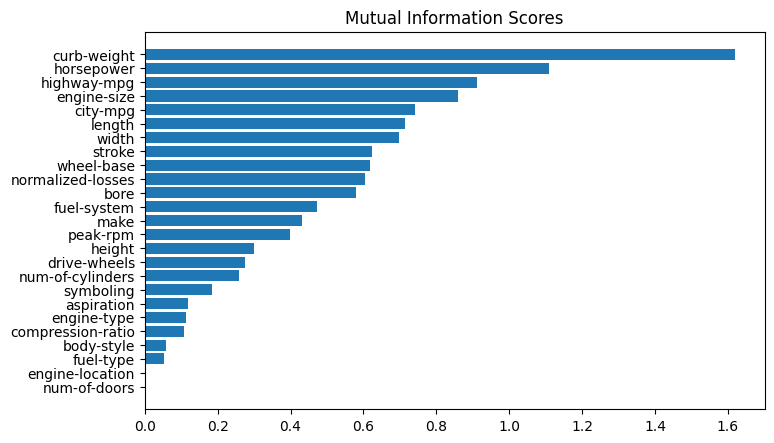

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

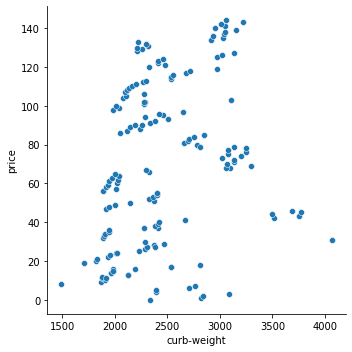

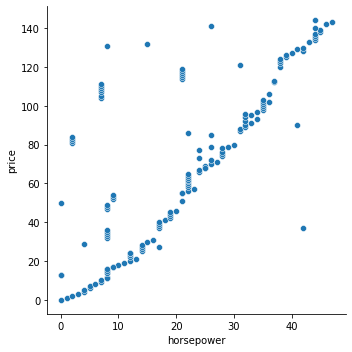

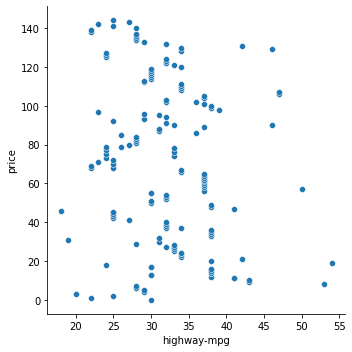

In [46]:
import seaborn as sns

sns.relplot(x="curb-weight", y="price", data=df_auto);
sns.relplot(x="horsepower", y="price", data=df_auto);
sns.relplot(x="highway-mpg", y="price", data=df_auto);

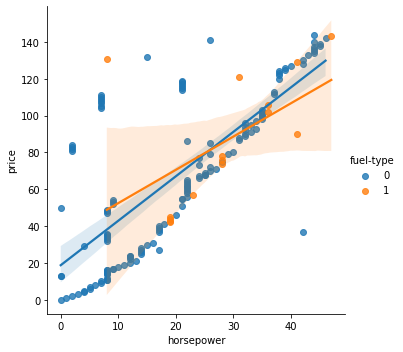

In [45]:
sns.lmplot(x="horsepower", y="price", hue="fuel-type", data=df_auto);

O recurso fuel_type tem uma pontuação de MI bastante baixa, mas, como podemos ver na figura, ele separa claramente duas populações de preços com tendências diferentes dentro do recurso de potência. Isso indica que fuel_type contribui com um efeito de interação e pode não ser sem importância, afinal. 

Antes de decidir que um recurso não é importante a partir de sua pontuação de MI, é bom investigar quaisquer possíveis efeitos de interação - o conhecimento do domínio pode oferecer muita orientação aqui.

## Creating Features

### Transformações matemáticas

As relações entre características numéricas são muitas vezes expressas por meio de fórmulas matemáticas, que você frequentemente encontrará como parte de sua pesquisa de domínio. No Pandas, você pode aplicar operações aritméticas a colunas como se fossem números comuns.

No conjunto de dados Automobile estão as características que descrevem o motor de um carro. A pesquisa produz uma variedade de fórmulas para criar novos recursos potencialmente úteis. A "taxa de curso", por exemplo, é uma medida de quão eficiente é um motor em relação ao seu desempenho:

In [59]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999

df_auto = pd.read_csv('/home/franciscofoz/Documents/GitHub/machine-learning-training/Datasets/Automobile_data.csv')
# Codificar o elemento categórico
for nome_coluna in df_auto.select_dtypes("object"):
    df_auto[nome_coluna], _ = df_auto[nome_coluna].factorize()

# Todas as features discretas que agora são int
features_discretas_df_auto = df_auto.dtypes == int


In [60]:
df_auto

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,0,0,0,0,0,0,0,0,88.6,168.8,64.1,48.8,2548,0,0,130,0,0,0,9.0,0,0,21,27,0
1,3,0,0,0,0,0,0,0,0,88.6,168.8,64.1,48.8,2548,0,0,130,0,0,0,9.0,0,0,21,27,1
2,1,0,0,0,0,0,1,0,0,94.5,171.2,65.5,52.4,2823,1,1,152,0,1,1,9.0,1,0,19,26,1
3,2,1,1,0,0,1,2,1,0,99.8,176.6,66.2,54.3,2337,2,0,109,0,2,2,10.0,2,1,24,30,2
4,2,1,1,0,0,1,2,2,0,99.4,176.6,66.4,54.3,2824,2,2,136,0,2,2,8.0,3,1,18,22,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,51,21,0,0,1,2,0,0,109.1,188.8,68.9,55.5,2952,2,0,141,0,24,16,9.5,56,4,23,28,182
201,-1,51,21,0,1,1,2,0,0,109.1,188.8,68.8,55.5,3049,2,0,141,0,24,16,8.7,6,23,19,25,183
202,-1,51,21,0,0,1,2,0,0,109.1,188.8,68.9,55.5,3012,1,1,173,0,21,36,8.8,58,1,18,23,184
203,-1,51,21,1,1,1,2,0,0,109.1,188.8,68.9,55.5,3217,2,1,145,6,38,2,23.0,59,6,26,27,185


In [61]:
df_auto["stroke_ratio"] = df_auto.stroke / df_auto.bore

df_auto[["stroke", "bore", "stroke_ratio"]]

,stroke,bore,stroke_ratio
0,0,0,NaN
1,0,0,NaN
2,1,1,1.000000
3,2,2,1.000000
4,2,2,1.000000
...,...,...,...
200,16,24,0.666667
201,16,24,0.666667
202,36,21,1.714286
203,2,38,0.052632


Quanto mais complicada for uma combinação, mais difícil será para um modelo aprender, como esta fórmula para o "deslocamento" de um motor, uma medida de sua potência:

In [62]:
df_auto

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,stroke_ratio
0,3,0,0,0,0,0,0,0,0,88.6,168.8,64.1,48.8,2548,0,0,130,0,0,0,9.0,0,0,21,27,0,NaN
1,3,0,0,0,0,0,0,0,0,88.6,168.8,64.1,48.8,2548,0,0,130,0,0,0,9.0,0,0,21,27,1,NaN
2,1,0,0,0,0,0,1,0,0,94.5,171.2,65.5,52.4,2823,1,1,152,0,1,1,9.0,1,0,19,26,1,1.000000
3,2,1,1,0,0,1,2,1,0,99.8,176.6,66.2,54.3,2337,2,0,109,0,2,2,10.0,2,1,24,30,2,1.000000
4,2,1,1,0,0,1,2,2,0,99.4,176.6,66.4,54.3,2824,2,2,136,0,2,2,8.0,3,1,18,22,3,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,51,21,0,0,1,2,0,0,109.1,188.8,68.9,55.5,2952,2,0,141,0,24,16,9.5,56,4,23,28,182,0.666667
201,-1,51,21,0,1,1,2,0,0,109.1,188.8,68.8,55.5,3049,2,0,141,0,24,16,8.7,6,23,19,25,183,0.666667
202,-1,51,21,0,0,1,2,0,0,109.1,188.8,68.9,55.5,3012,1,1,173,0,21,36,8.8,58,1,18,23,184,1.714286
203,-1,51,21,1,1,1,2,0,0,109.1,188.8,68.9,55.5,3217,2,1,145,6,38,2,23.0,59,6,26,27,185,0.052632


In [63]:
df_auto["displacement"] = (
    np.pi * ((0.5 * df_auto.bore) ** 2) * df_auto.stroke * df_auto['num-of-cylinders'])

df_auto[['bore','stroke','num-of-cylinders','displacement']]

,bore,stroke,num-of-cylinders,displacement
0,0,0,0,0.000000
1,0,0,0,0.000000
2,1,1,1,0.785398
3,2,2,0,0.000000
4,2,2,2,12.566371
...,...,...,...,...
200,24,16,0,0.000000
201,24,16,0,0.000000
202,21,36,1,12468.981242
203,38,2,1,2268.229896


## Counts

In [1]:
import pandas as pd

As características que descrevem a presença ou ausência de algo geralmente vêm em conjuntos, digamos, o conjunto de fatores de risco para uma doença. Você pode agregar esses recursos criando uma contagem.

Esses recursos serão binários (1 para Presente, 0 para Ausente) ou booleanos (Verdadeiro ou Falso). Em Python, os booleanos podem ser somados como se fossem inteiros.

Em Acidentes de Trânsito existem diversas funcionalidades que indicam se algum objeto da via esteve próximo ao acidente. Isso criará uma contagem do número total de recursos de rodovia próximos usando o método de soma:

Você também pode usar os métodos internos de um dataframe para criar valores booleanos. 

No conjunto de dados Concreto estão as quantidades de componentes em uma formulação concreta.

Muitas formulações carecem de um ou mais componentes (ou seja, o componente tem um valor de 0). 

Isso contará quantos componentes estão em uma formulação com o método de maior que gt interno do quadro de dados:

## Building-Up and Breaking-Down Features